In [ ]:
 >>> nltk.download('stopwords')

In [4]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist

import nltk
import string
# nltk.download('stopwords')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src import nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

from joblib import parallel_backend

import dask.array as da

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Wall Street Forum Topic Modeling

## Data Import and Tf-Idf Vectorization

In [5]:
wallstreet = pd.read_csv('data/wallstreet_master.csv', engine='python')
wallstreet['lemmatized_tokens'] = wallstreet['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))
docs_raw = [' '.join(d) for d in wallstreet['lemmatized_tokens']]

In [6]:
n_topics = 20
max_doc_freq = 0.7
min_doc_freq = 4
max_features = 10000
ngram_rng = [1, 2]
max_iterations = 25
random_state=3
min_len = 1

In [7]:
docs_vectorized, vectorizer = nlp_topic_utils.tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_features, ngram_rng)

## TruncatedSVD

In [ ]:
type(docs_vectorized)

In [10]:
docs_dask_arr = da.from_array(docs_vectorized, chunks='auto', asarray=True)

In [12]:
docs_dask_arr.shape

(45372, 10000)

In [8]:
def select_tsvd_num_components(var_ratio, var_explained_threshold):
    '''
    Determines the number of components required for TruncatedSVD to achieve the threshold of variance explained.
    '''
    total_var = 0
    n_components = 0
    
    for explained_var in var_ratio:
        total_var += explained_var
        n_components += 1
        
        if total_var >= goal_var:
            break
    
    return n_components

In [13]:
docs_dask_arr.shape

(45372, 10000)

In [15]:
#with parallel_backend('threading', n_jobs=-1):
tsvd = TruncatedSVD(n_components=docs_dask_arr.shape[1]-1)
docs_tsvd = tsvd.fit(docs_vectorized)

In [ ]:
# Identify the required number of components to achieve the desired threshold of variance explained.
var_explained_threshold = 0.90

tsvd_var_ratios = tsvd.explained_variance_ratio_
tsvd_num_components = select_tsvd_num_components(tsvd_var_ratios, var_explained_threshold)

In [9]:
# with parallel_backend('threading', n_jobs=-1):
tsvd = TruncatedSVD(n_components=tsvd_num_components, random_state=random_state)
docs_tsvd = tsvd.fit_transform(docs_vectorized)

NameError: name 'tsvd_num_components' is not defined

---
## K-Means

In [20]:
docs_vectorized.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'Sum of Squared Errors')

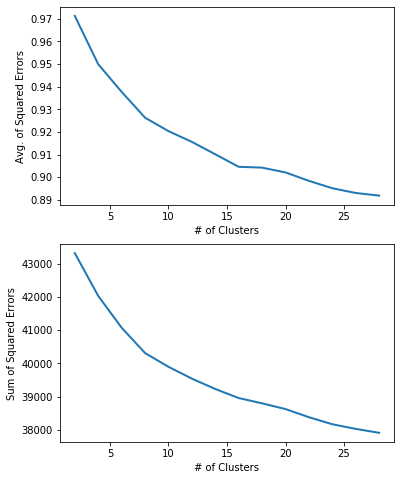

In [21]:
# Identify number of cluseters using the "Elbow" method

# distortion is the average of the squared distances from the cluster centers of the respective clusters.
distortions = []
distortion_map = {}

# Inertia is the sum of squared distances of samples to their closest cluster center
inertias = []
inertia_map = {}

k_rng = np.arange(2, 30, 2)

for k in k_rng:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(docs_vectorized)
    pred = kmeans.predict(docs_vectorized)
    centroids = kmeans.cluster_centers_
    
    d = sum(np.min(cdist(docs_vectorized.toarray(), centroids, metric='euclidean'), axis=1)) / docs_vectorized.shape[0]
    distortions.append(d)
    distortion_map[k] = d
    
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

ax[0].plot(k_rng, distortions, linewidth=2)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Avg. of Squared Errors')

ax[1].plot(k_rng, inertias, linewidth=2)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Sum of Squared Errors')
    


In [22]:
# Instiate KMeans model object.
# Input k
best_k = 18
kmeans = KMeans(n_clusters=best_k, random_state=random_state)
kmeans.fit(docs_vectorized)

KMeans(n_clusters=18, random_state=3)

In [27]:
print(k_clusters_centers.shape)

(18, 10000)


In [28]:
clusters = kmeans.labels_
k_clusters_centers = kmeans.cluster_centers_
# original_space_centroids = tsvd.inverse_transform(k_clusters_centers)
# argsort() returns the indices of the sorted values.
ordered_centroids = k_clusters_centers.argsort()[:, ::-1]

In [37]:
k_clusters_centers.shape

(18, 10000)

In [39]:
words.shape

AttributeError: 'function' object has no attribute 'shape'

In [41]:
n_top_words = 10
words = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(k_clusters_centers):
        top_words_arr = [words[i] for i in ordered_centroids[topic_idx, : n_top_words]]
        print("\nCluster #{}:".format(topic_idx))
        print(" ".join(top_words_arr))


Cluster #0:
market wrote thanks need store looking pm offer check good

Cluster #1:
external contact external contact allowed link allowed rule read contact link allowed read read rule

Cluster #2:
bump bump market market store store wsm store market wsm del market profile bonus

Cluster #3:
act rebellion deal unfree unfree free existence rebellion existence act become absolutely unfree world absolutely free world become

Cluster #4:
eskimo arab drug consider testicle eskimo sand sand arab testicle smashed ice eskimo smashed ice drug nun testicle

Cluster #5:
key pgp public key public pgp public key block block pgp key message begin

Cluster #6:
use mirror mirror onionshop onionshop mirror onionshop use use ghb sample good vendor

Cluster #7:
phished rule help phished wsm help phished rule help wsm broder wrote welcome

Cluster #8:
bank drop account bank drop paypal transfer need method cashout money

Cluster #9:
shoutouts dont break dabbingtimes hero shoutouts supermod boneskoopa kno